In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import cv2
import matplotlib.pyplot as plt
import copy

2023-08-25 22:11:08.506269: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-25 22:11:09.972419: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/zoid/miniconda3/envs/ai/lib/
2023-08-25 22:11:09.972513: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/zoid/miniconda3/envs/ai/lib/
2023-08-25 22:11:09.972519: W tensorflow/compiler/tf2tenso

In [2]:
img_height = 200
img_width = 400
original_img_height = 200
original_img_width = 400

In [3]:
def preprocess_image(img_path):
    img = cv2.imread(img_path)
    global original_img_height, original_img_width
    original_img_height, original_img_width = img.shape[0], img.shape[1]
    img = cv2.resize(img, (img_width, img_height))
    img = np.expand_dims(img, axis=0)
    img = keras.applications.vgg19.preprocess_input(img)
    return img

def deprocess_image(img):
    img = cv2.resize(img, (original_img_width, original_img_height))
    # Remove zero-center by mean pixel
    img[:, :, 0] += 103.939
    img[:, :, 1] += 116.779
    img[:, :, 2] += 123.68
    # BGR to RGB
    img = img[:, :, ::-1]
    img = np.clip(img, 0, 255).astype('uint8')
    return img

In [4]:
def content_loss(P, F):
    return 0.5*tf.reduce_sum(tf.square(F - P))

def gram_matrix(x):
    x = tf.matmul(x, tf.transpose(x))
    return x

def style_loss(F, G):
    gram_F = gram_matrix(F)
    gram_G = gram_matrix(G)
    return tf.reduce_sum(tf.square(gram_F - gram_G)) / (4. * (F.shape[0] * F.shape[1])**2)

def total_variation_loss(x):
    a = tf.square(
        x[:, : -1, : -1, :] - x[:, 1:, : - 1, :]
    )
    b = tf.square(
        x[:, : -1 , : - 1, :] - x[:, : - 1, 1:, :]
    )
    return tf.reduce_sum(tf.pow(a+b, 1.25))
    

In [5]:
vgg = keras.applications.vgg19.VGG19(include_top=False, weights='imagenet')
layers_dict = dict([(layer.name, layer.output) for layer in vgg.layers])

feature_extractor = keras.Model(vgg.input , layers_dict)

2023-08-25 22:11:11.697407: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-08-25 22:11:11.751048: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-08-25 22:11:11.751404: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-08-25 22:11:11.752936: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorF

In [6]:
base = preprocess_image('target.jpg')
style = preprocess_image('style.jpg')
combination = tf.Variable(copy.deepcopy(base))

style_layer = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']
content_layer = 'block5_conv2'

Iteration: 0  Loss = 13358.1650390625


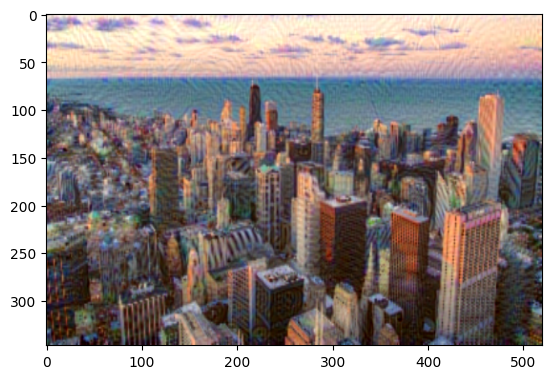

Iteration: 100  Loss = 8076.08203125


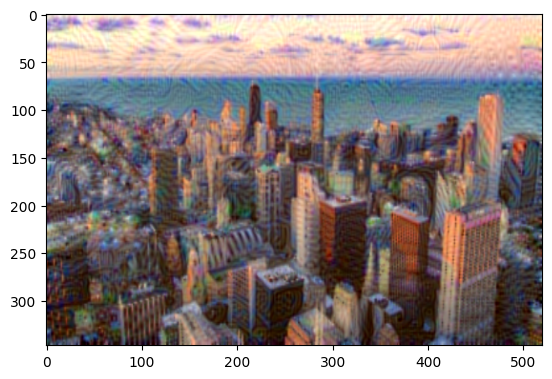

Iteration: 200  Loss = 5978.33740234375


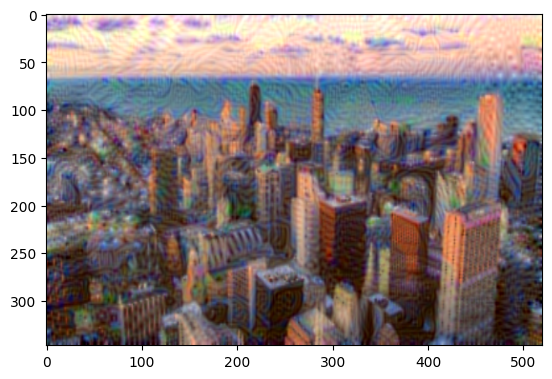

Iteration: 300  Loss = 4931.0478515625


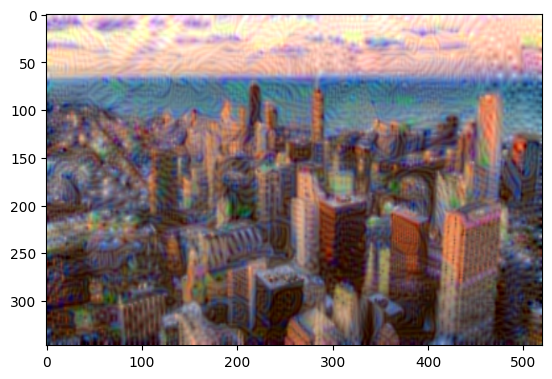

Iteration: 400  Loss = 4335.2197265625


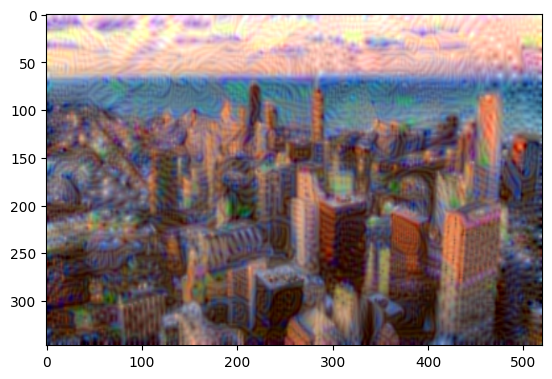

In [9]:
optimizer = tf.optimizers.Adam(learning_rate=0.1)
iterations = 500
alpha = 2.5e-7
beta = 1e-5
gamma = 1e-5

for i in range(iterations):
    with tf.GradientTape() as tape:
        x = feature_extractor(base)
        y = feature_extractor(style)
        z = feature_extractor(combination)

        style_l = tf.zeros(shape=())
        content_l = tf.zeros(shape=())

        for layer in style_layer:
            t = y[layer][0]
            t = tf.reshape(tf.transpose(t, (2, 0, 1)), (tf.shape(t)[0], -1))
            q = z[layer][0]
            q = tf.reshape(tf.transpose(q, (2, 0, 1)), (tf.shape(q)[0], -1))
            style_l += style_loss(t, q)
        
        t = x[content_layer]
        t = tf.reshape(t, (t.shape[-1], -1))
        q = z[content_layer]
        q = tf.reshape(q, (q.shape[-1], -1))
        content_l += content_loss(t, q)

        variation_l = tf.zeros(shape=())
        variation_l = total_variation_loss(combination)

        total_loss = alpha*content_l + beta*style_l + gamma*variation_l

    grads = tape.gradient(total_loss, combination)
    optimizer.apply_gradients([(grads, combination)])

    if i % 100 == 0:
        print("Iteration: {}  Loss = {}".format(i, total_loss))
        img = deprocess_image(np.array(combination[0][:,:,::-1]))
        plt.imshow(img)
        plt.show()
    

In [ ]:
img = deprocess_image(np.array(combination[0][:,:,::-1]))
keras.utils.save_img(f"combination_image.jpg", img)